[*********************100%***********************]  1 of 1 completed


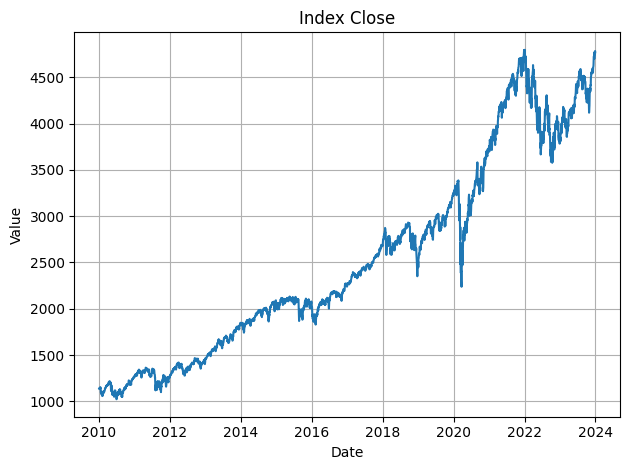

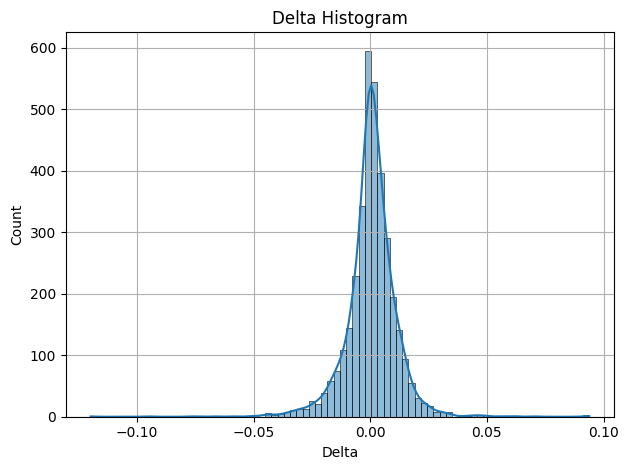

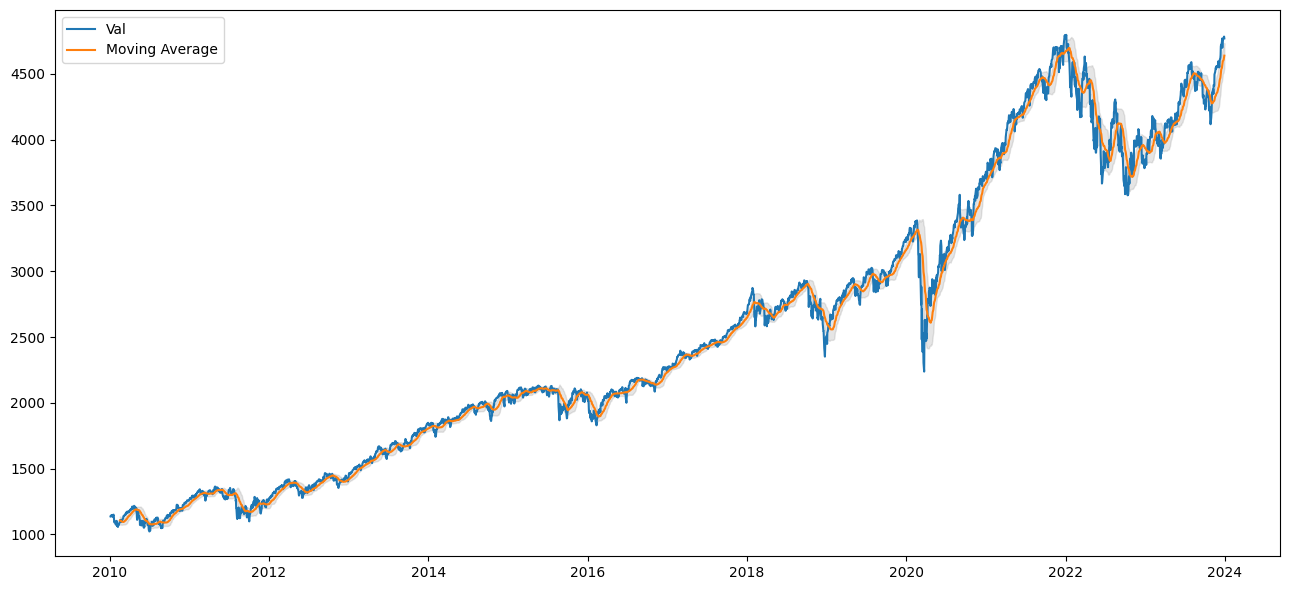

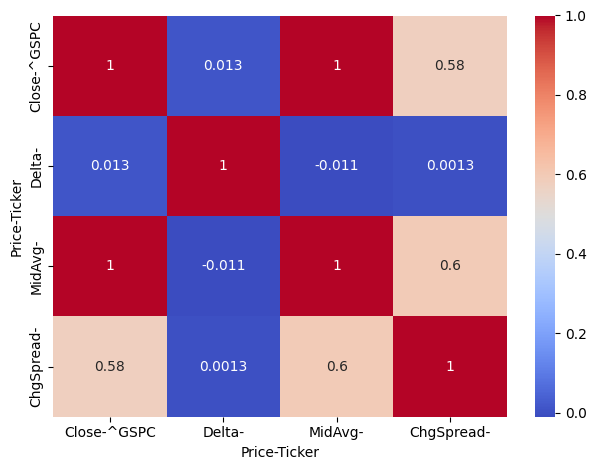

Fitting 3 folds for each of 24 candidates, totalling 72 fits


c:\Users\ksoha\OneDrive\Documents\GitHub\collegecourses\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ksoha\OneDrive\Documents\GitHub\collegecourses\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ksoha\OneDrive\Documents\GitHub\collegecourses\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ksoha\OneDrive\Documents\GitHub\collegecourses\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWa

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


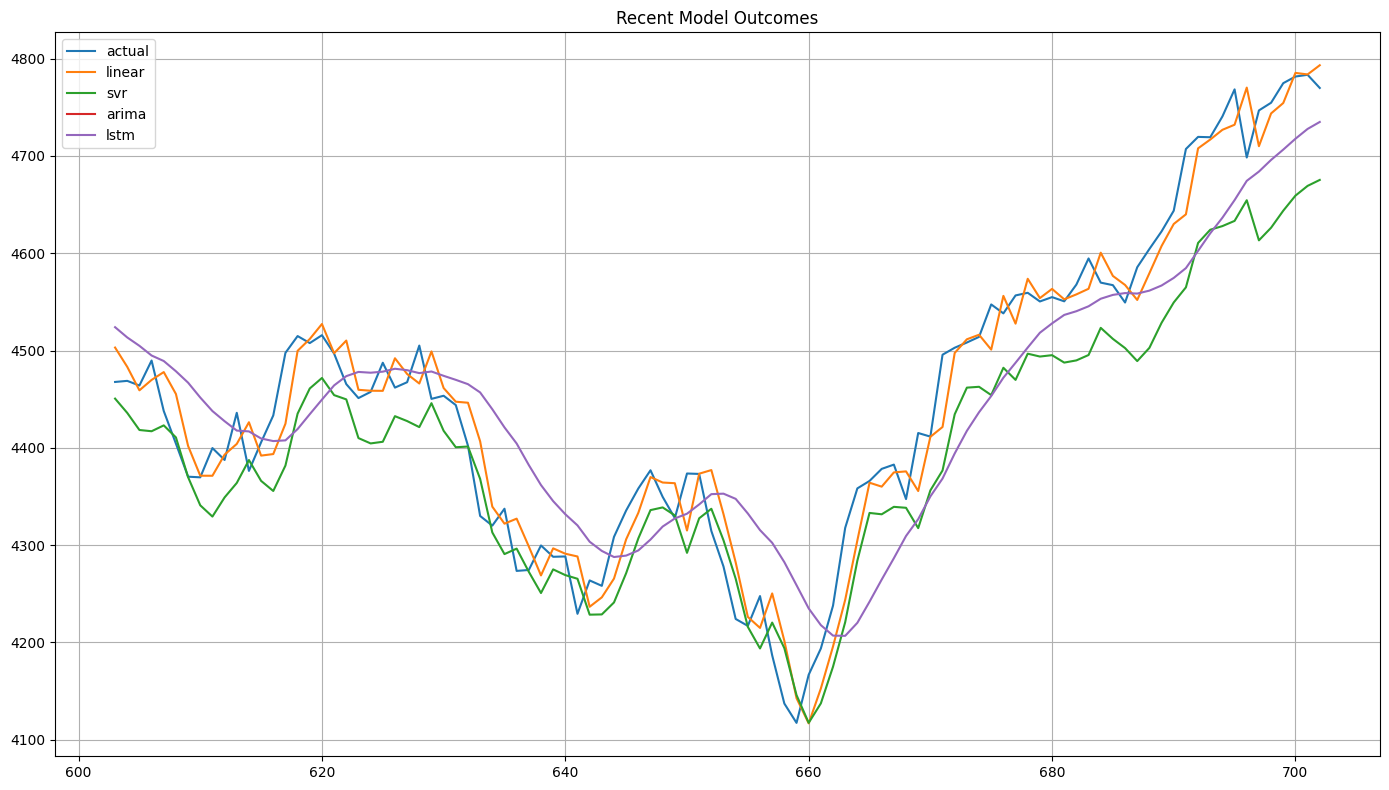

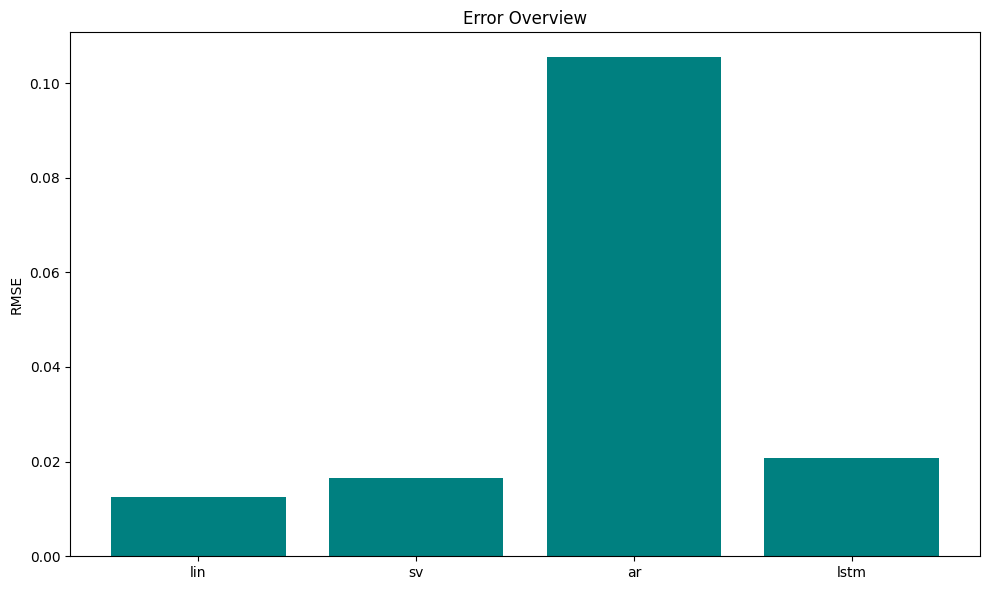

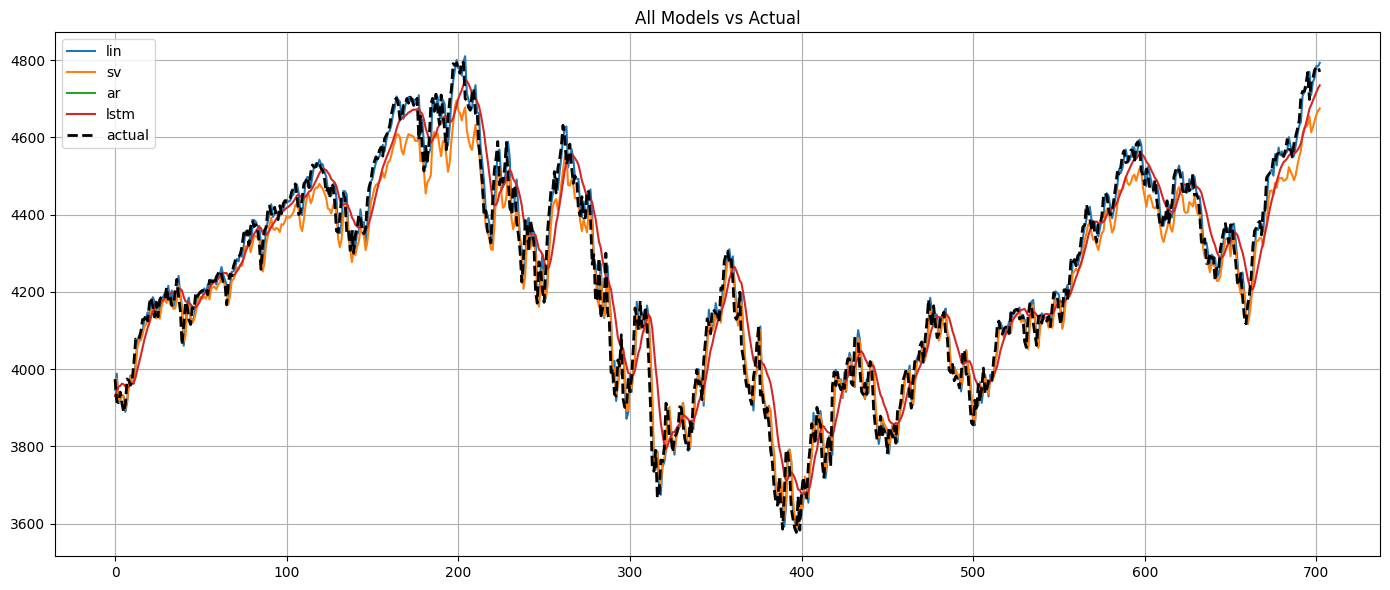


Model Score Summary:
  Model    RMSE     MAE      R2
0   lin  0.0125  0.0095  0.9704
1    sv  0.0165  0.0135  0.9487
2    ar  0.1054  0.0877 -1.0944
3  lstm  0.0207  0.0159  0.9190


In [10]:
# NOTE: This script explores multiple ML models on S&P 500 stock data

import yfinance as yfn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from math import sqrt

symbol = '^GSPC'
dataframe = yfn.download(symbol, start='2010-01-01', end='2024-01-01')
dataframe = dataframe[['Close']].dropna()
dataframe['Delta'] = dataframe['Close'].pct_change()
dataframe.dropna(inplace=True)

plt.plot(dataframe['Close'])
plt.title('Index Close')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

sbn.histplot(dataframe['Delta'], bins=80, kde=True)
plt.title('Delta Histogram')
plt.grid(True)
plt.tight_layout()
plt.show()

window = 30
dataframe['MidAvg'] = dataframe['Close'].rolling(window).mean()
dataframe['ChgSpread'] = dataframe['Close'].rolling(window).std()

plt.figure(figsize=(13, 6))
plt.plot(dataframe['Close'], label='Val')
plt.plot(dataframe['MidAvg'], label='Moving Average')
plt.fill_between(dataframe.index, dataframe['MidAvg'] - dataframe['ChgSpread'], dataframe['MidAvg'] + dataframe['ChgSpread'], color='gray', alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()

sbn.heatmap(dataframe.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.tight_layout()
plt.show()

normz = MinMaxScaler()
dataframe['Norm'] = normz.fit_transform(dataframe[['Close']])


def structure_pairs(data, steps=10):
    features, labels = [], []
    for i in range(len(data) - steps):
        features.append(data[i:i+steps])
        labels.append(data[i+steps])
    return np.array(features), np.array(labels)

span = 10
xx, yy = structure_pairs(dataframe['Norm'].values, span)
xx_tr, xx_te, yy_tr, yy_te = train_test_split(xx, yy, test_size=0.2, shuffle=False)

model_errors = {}
mae_vals = {}
r2_vals = {}
out_df = pd.DataFrame(index=range(len(yy_te)))

regr = LinearRegression()
regr.fit(xx_tr.reshape(len(xx_tr), -1), yy_tr)
predict_lr = regr.predict(xx_te.reshape(len(xx_te), -1))
model_errors['lin'] = sqrt(mean_squared_error(yy_te, predict_lr))
mae_vals['lin'] = mean_absolute_error(yy_te, predict_lr)
r2_vals['lin'] = r2_score(yy_te, predict_lr)
out_df['lin_pred'] = predict_lr
out_df['lin_val'] = normz.inverse_transform(predict_lr.reshape(-1, 1)).flatten()

'''forest = GridSearchCV(RandomForestRegressor(), {
    'n_estimators': [50],
    'max_depth': [10]
}, cv=3, scoring='neg_mean_squared_error')
forest.fit(xx_tr.reshape(len(xx_tr), -1), yy_tr)
predict_rf = forest.predict(xx_te.reshape(len(xx_te), -1))
model_errors['tree'] = sqrt(mean_squared_error(yy_te, predict_rf))
mae_vals['tree'] = mean_absolute_error(yy_te, predict_rf)
r2_vals['tree'] = r2_score(yy_te, predict_rf)
out_df['tree_pred'] = predict_rf
out_df['tree_val'] = normz.inverse_transform(predict_rf.reshape(-1, 1)).flatten()'''

from sklearn.pipeline import make_pipeline

# Enhanced SVR grid for better performance
svr_params = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__epsilon': [0.001, 0.01, 0.1],
    'svr__gamma': ['scale', 'auto']
}

svr_pipeline = make_pipeline(SVR())
svm = GridSearchCV(svr_pipeline, svr_params, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

svm.fit(xx_tr.reshape(len(xx_tr), -1), yy_tr)
predict_svr = svm.predict(xx_te.reshape(len(xx_te), -1))

model_errors['sv'] = sqrt(mean_squared_error(yy_te, predict_svr))
mae_vals['sv'] = mean_absolute_error(yy_te, predict_svr)
r2_vals['sv'] = r2_score(yy_te, predict_svr)
out_df['sv_pred'] = predict_svr
out_df['sv_val'] = normz.inverse_transform(predict_svr.reshape(-1, 1)).flatten()

'''svm = GridSearchCV(SVR(), {
    'C': [0.1, 1],
    'epsilon': [0.01, 0.1]
}, cv=2, scoring='neg_mean_squared_error')
svm.fit(xx_tr.reshape(len(xx_tr), -1), yy_tr)
predict_svr = svm.predict(xx_te.reshape(len(xx_te), -1))
model_errors['sv'] = sqrt(mean_squared_error(yy_te, predict_svr))
mae_vals['sv'] = mean_absolute_error(yy_te, predict_svr)
r2_vals['sv'] = r2_score(yy_te, predict_svr)
out_df['sv_pred'] = predict_svr
out_df['sv_val'] = normz.inverse_transform(predict_svr.reshape(-1, 1)).flatten()'''

true_vals = dataframe['Close']
cut_train, cut_test = true_vals[:-len(yy_te)], true_vals[-len(yy_te):]

from pmdarima import auto_arima
init_model = auto_arima(cut_train, seasonal=False, stepwise=True, suppress_warnings=True)
use_order = init_model.order
ar_fit = ARIMA(cut_train, order=use_order).fit()
ar_results = ar_fit.forecast(len(cut_test))
out_df['ar_val'] = ar_results
out_df['ar_pred'] = normz.transform(ar_results.values.reshape(-1, 1)).flatten()
model_errors['ar'] = sqrt(mean_squared_error(normz.transform(cut_test.values.reshape(-1, 1)).flatten(), out_df['ar_pred']))
mae_vals['ar'] = mean_absolute_error(normz.transform(cut_test.values.reshape(-1, 1)).flatten(), out_df['ar_pred'])
r2_vals['ar'] = r2_score(normz.transform(cut_test.values.reshape(-1, 1)).flatten(), out_df['ar_pred'])

seq_tr = xx_tr.reshape((xx_tr.shape[0], xx_tr.shape[1], 1))
seq_te = xx_te.reshape((xx_te.shape[0], xx_te.shape[1], 1))

lstm_net = Sequential()
lstm_net.add(LSTM(50, input_shape=(span, 1)))
lstm_net.add(Dense(1))
lstm_net.compile(optimizer='adam', loss='mse')
lstm_net.fit(seq_tr, yy_tr, epochs=10, batch_size=32, verbose=0)

predict_lstm = lstm_net.predict(seq_te)
model_errors['lstm'] = sqrt(mean_squared_error(yy_te, predict_lstm))
mae_vals['lstm'] = mean_absolute_error(yy_te, predict_lstm)
r2_vals['lstm'] = r2_score(yy_te, predict_lstm)
out_df['lstm_pred'] = predict_lstm.flatten()
out_df['lstm_val'] = normz.inverse_transform(predict_lstm).flatten()

out_df['actual_s'] = yy_te
out_df['actual_v'] = normz.inverse_transform(yy_te.reshape(-1, 1)).flatten()

plt.figure(figsize=(14, 8))
plt.plot(out_df['actual_v'][-100:], label='actual')
plt.plot(out_df['lin_val'][-100:], label='linear')
#plt.plot(out_df['tree_val'][-100:], label='forest')
plt.plot(out_df['sv_val'][-100:], label='svr')
plt.plot(out_df['ar_val'][-100:], label='arima')
plt.plot(out_df['lstm_val'][-100:], label='lstm')
plt.legend()
plt.title('Recent Model Outcomes')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(model_errors.keys(), model_errors.values(), color='teal')
plt.ylabel('RMSE')
plt.title('Error Overview')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
for col in ['lin_val', 'sv_val', 'ar_val', 'lstm_val']: #, 'tree_val'
    plt.plot(out_df[col], label=col.replace('_val', ''))
plt.plot(out_df['actual_v'], label='actual', linewidth=2, linestyle='--', color='black')
plt.legend()
plt.title('All Models vs Actual')
plt.grid(True)
plt.tight_layout()
plt.show()

summary_sheet = pd.DataFrame({
    'Model': list(model_errors.keys()),
    'RMSE': list(model_errors.values()),
    'MAE': [mae_vals[m] for m in model_errors.keys()],
    'R2': [r2_vals[m] for m in model_errors.keys()]
})

print("\nModel Score Summary:")
print(summary_sheet.round(4))


[*********************100%***********************]  1 of 1 completed


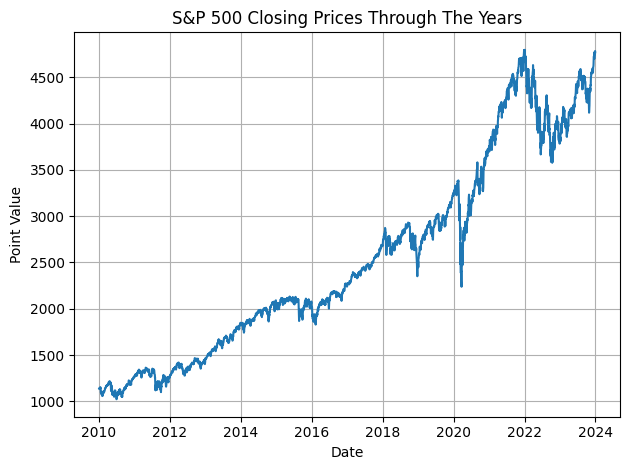

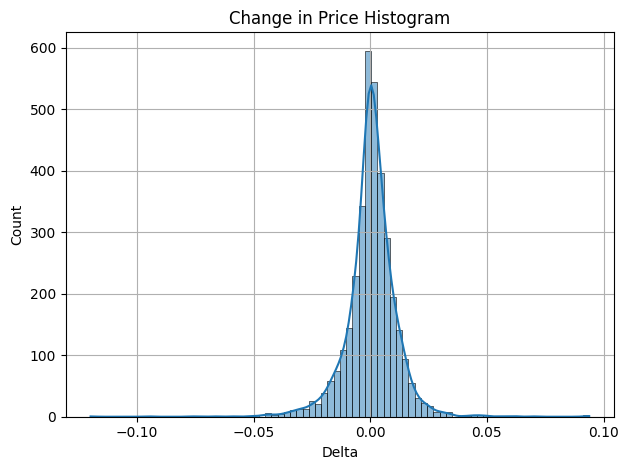

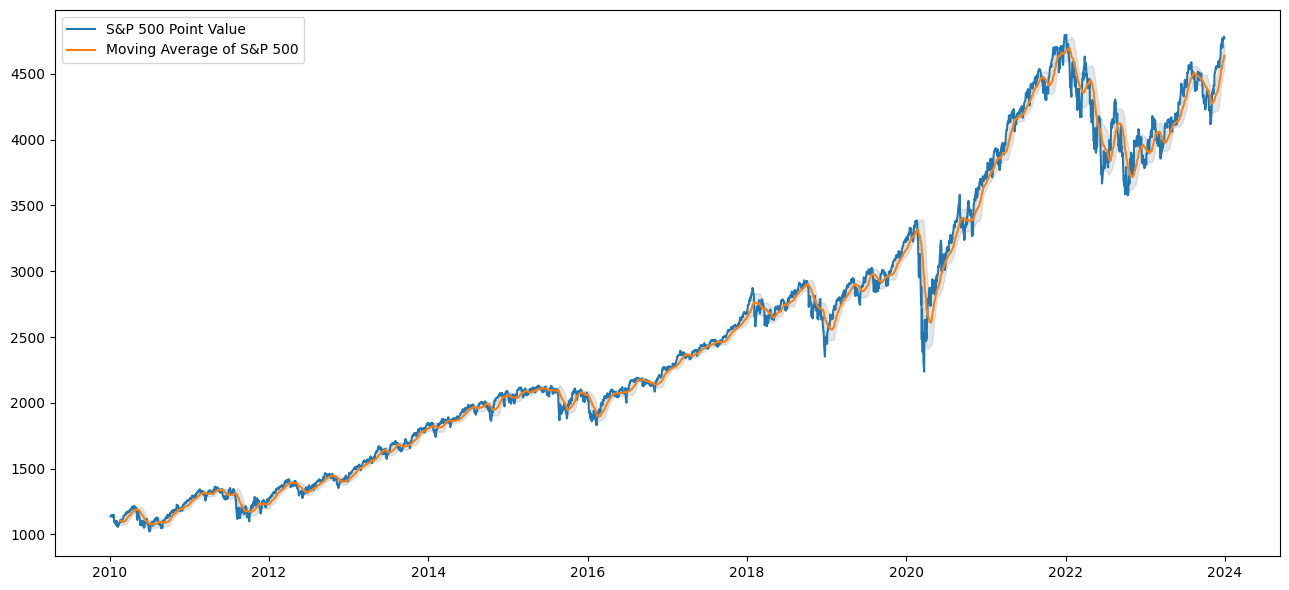

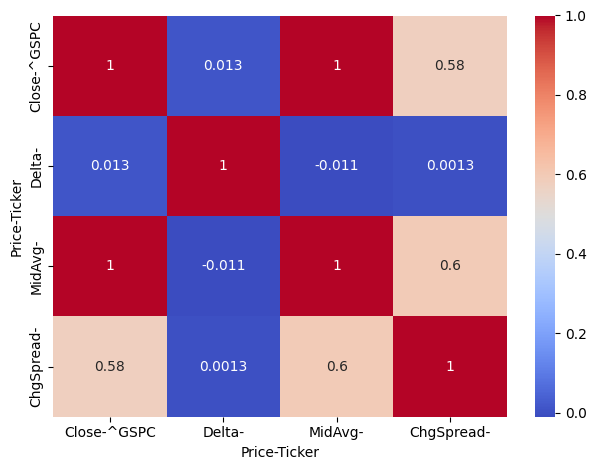

Fitting 3 folds for each of 24 candidates, totalling 72 fits


c:\Users\ksoha\OneDrive\Documents\GitHub\collegecourses\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ksoha\OneDrive\Documents\GitHub\collegecourses\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ksoha\OneDrive\Documents\GitHub\collegecourses\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ksoha\OneDrive\Documents\GitHub\collegecourses\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWa

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


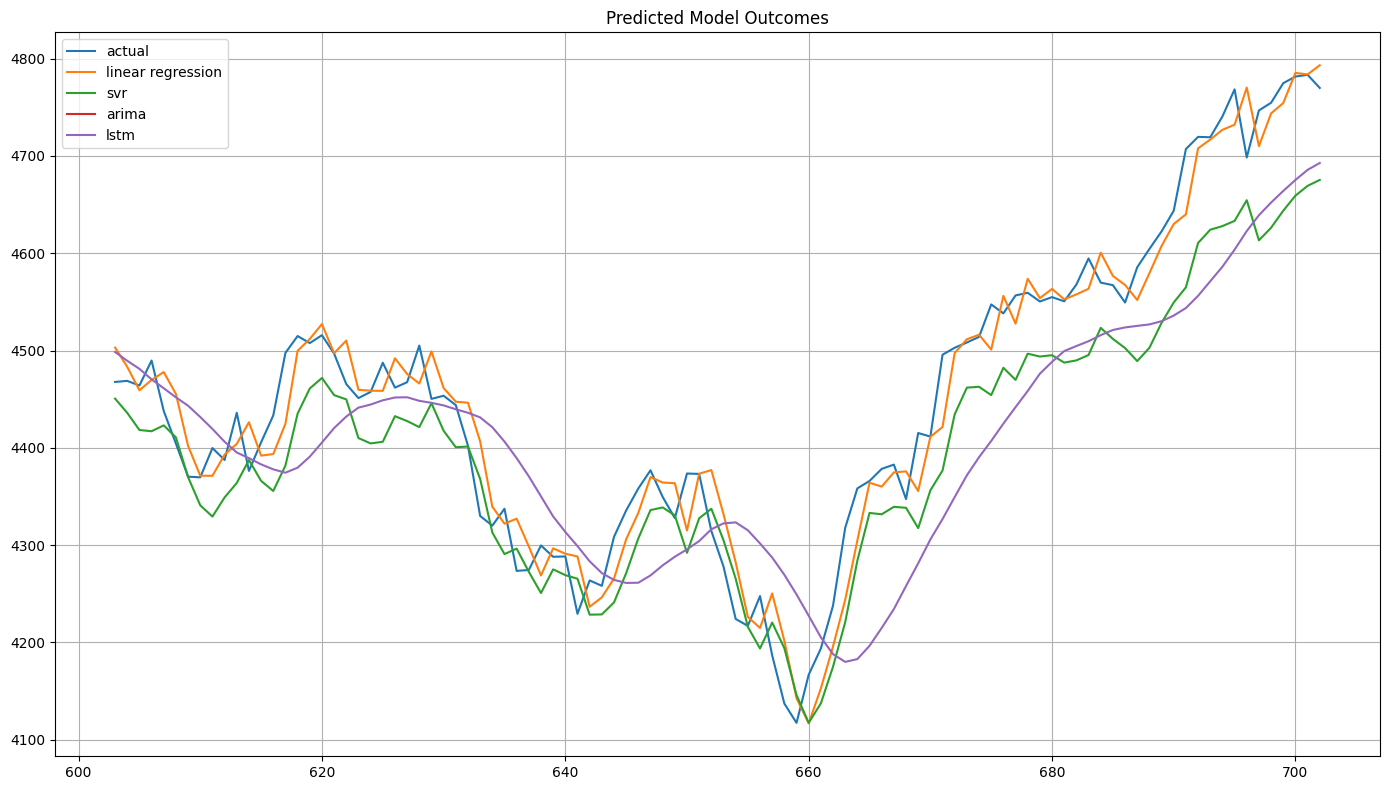

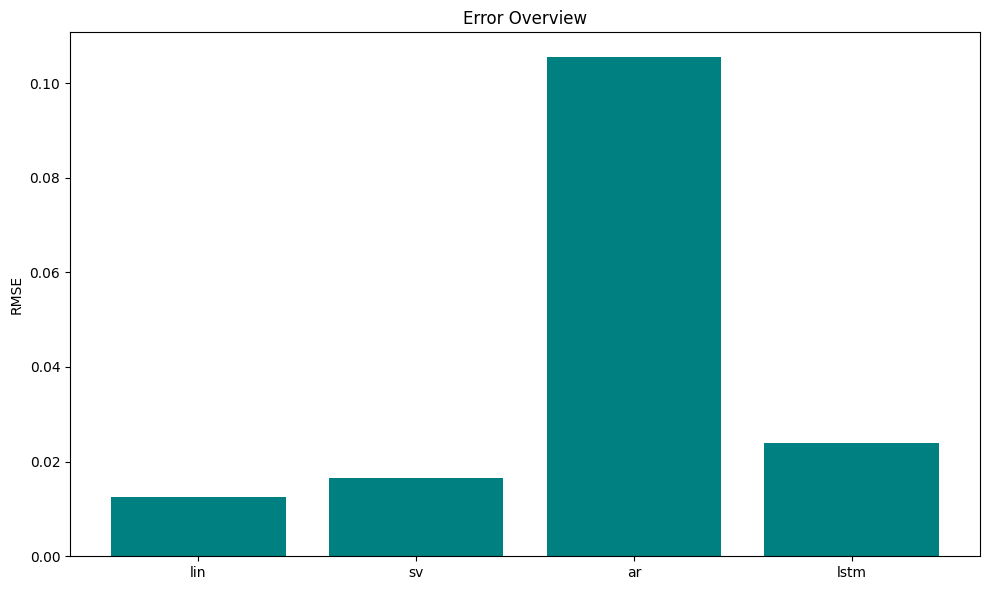

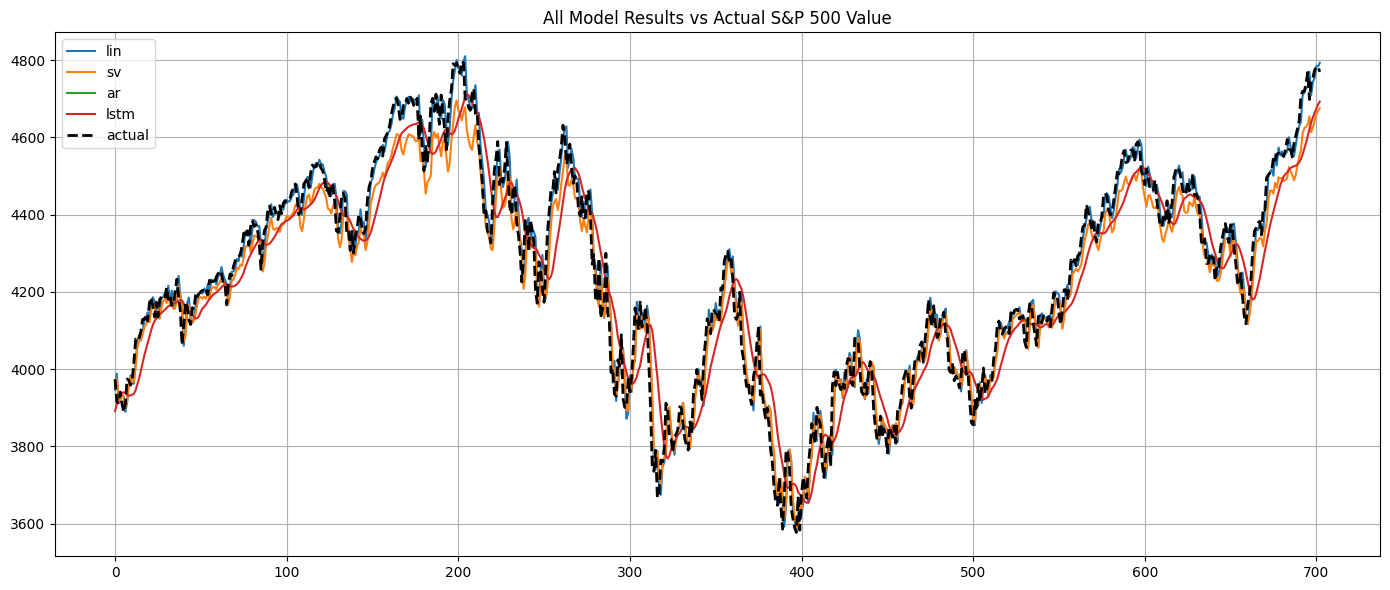


Model Score Summary:
  Model    RMSE     MAE      R2
0   lin  0.0125  0.0095  0.9704
1    sv  0.0165  0.0135  0.9487
2    ar  0.1054  0.0877 -1.0944
3  lstm  0.0239  0.0194  0.8927


In [14]:
# NOTE: This script explores multiple ML models on S&P 500 stock data

import yfinance as yfn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from math import sqrt

symbol = '^GSPC'
dataframe = yfn.download(symbol, start='2010-01-01', end='2024-01-01')
dataframe = dataframe[['Close']].dropna()
dataframe['Delta'] = dataframe['Close'].pct_change()
dataframe.dropna(inplace=True)

plt.plot(dataframe['Close'])
plt.title('S&P 500 Closing Prices Through The Years')
plt.xlabel('Date')
plt.ylabel('Point Value')
plt.grid(True)
plt.tight_layout()
plt.show()

sbn.histplot(dataframe['Delta'], bins=80, kde=True)
plt.title('Change in Price Histogram')
plt.grid(True)
plt.tight_layout()
plt.show()

window = 30
dataframe['MidAvg'] = dataframe['Close'].rolling(window).mean()
dataframe['ChgSpread'] = dataframe['Close'].rolling(window).std()

plt.figure(figsize=(13, 6))
plt.plot(dataframe['Close'], label='S&P 500 Point Value')
plt.plot(dataframe['MidAvg'], label='Moving Average of S&P 500')
plt.fill_between(dataframe.index, dataframe['MidAvg'] - dataframe['ChgSpread'], dataframe['MidAvg'] + dataframe['ChgSpread'], color='gray', alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()

sbn.heatmap(dataframe.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.tight_layout()
plt.show()

normz = MinMaxScaler()
dataframe['Norm'] = normz.fit_transform(dataframe[['Close']])


def structure_pairs(data, steps=10):
    features, labels = [], []
    for i in range(len(data) - steps):
        features.append(data[i:i+steps])
        labels.append(data[i+steps])
    return np.array(features), np.array(labels)

span = 10
xx, yy = structure_pairs(dataframe['Norm'].values, span)
xx_tr, xx_te, yy_tr, yy_te = train_test_split(xx, yy, test_size=0.2, shuffle=False)

model_errors = {}
mae_vals = {}
r2_vals = {}
out_df = pd.DataFrame(index=range(len(yy_te)))

regr = LinearRegression()
regr.fit(xx_tr.reshape(len(xx_tr), -1), yy_tr)
predict_lr = regr.predict(xx_te.reshape(len(xx_te), -1))
model_errors['lin'] = sqrt(mean_squared_error(yy_te, predict_lr))
mae_vals['lin'] = mean_absolute_error(yy_te, predict_lr)
r2_vals['lin'] = r2_score(yy_te, predict_lr)
out_df['lin_pred'] = predict_lr
out_df['lin_val'] = normz.inverse_transform(predict_lr.reshape(-1, 1)).flatten()

"""forest = GridSearchCV(RandomForestRegressor(), {
    'n_estimators': [50],
    'max_depth': [10]
}, cv=3, scoring='neg_mean_squared_error')
forest.fit(xx_tr.reshape(len(xx_tr), -1), yy_tr)
predict_rf = forest.predict(xx_te.reshape(len(xx_te), -1))
model_errors['tree'] = sqrt(mean_squared_error(yy_te, predict_rf))
mae_vals['tree'] = mean_absolute_error(yy_te, predict_rf)
r2_vals['tree'] = r2_score(yy_te, predict_rf)
out_df['tree_pred'] = predict_rf
out_df['tree_val'] = normz.inverse_transform(predict_rf.reshape(-1, 1)).flatten()

svm = GridSearchCV(SVR(), {
    'C': [0.1, 1],
    'epsilon': [0.01, 0.1]
}, cv=2, scoring='neg_mean_squared_error')
svm.fit(xx_tr.reshape(len(xx_tr), -1), yy_tr)
predict_svr = svm.predict(xx_te.reshape(len(xx_te), -1))
model_errors['sv'] = sqrt(mean_squared_error(yy_te, predict_svr))
mae_vals['sv'] = mean_absolute_error(yy_te, predict_svr)
r2_vals['sv'] = r2_score(yy_te, predict_svr)
out_df['sv_pred'] = predict_svr
out_df['sv_val'] = normz.inverse_transform(predict_svr.reshape(-1, 1)).flatten()"""

from sklearn.pipeline import make_pipeline

# Enhanced SVR grid for better performance
svr_params = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__epsilon': [0.001, 0.01, 0.1],
    'svr__gamma': ['scale', 'auto']
}

svr_pipeline = make_pipeline(SVR())
svm = GridSearchCV(svr_pipeline, svr_params, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

svm.fit(xx_tr.reshape(len(xx_tr), -1), yy_tr)
predict_svr = svm.predict(xx_te.reshape(len(xx_te), -1))

model_errors['sv'] = sqrt(mean_squared_error(yy_te, predict_svr))
mae_vals['sv'] = mean_absolute_error(yy_te, predict_svr)
r2_vals['sv'] = r2_score(yy_te, predict_svr)
out_df['sv_pred'] = predict_svr
out_df['sv_val'] = normz.inverse_transform(predict_svr.reshape(-1, 1)).flatten()


true_vals = dataframe['Close']
cut_train, cut_test = true_vals[:-len(yy_te)], true_vals[-len(yy_te):]

from pmdarima import auto_arima
init_model = auto_arima(cut_train, seasonal=False, stepwise=True, suppress_warnings=True)
use_order = init_model.order
ar_fit = ARIMA(cut_train, order=use_order).fit()
ar_results = ar_fit.forecast(len(cut_test))
out_df['ar_val'] = ar_results
out_df['ar_pred'] = normz.transform(ar_results.values.reshape(-1, 1)).flatten()
model_errors['ar'] = sqrt(mean_squared_error(normz.transform(cut_test.values.reshape(-1, 1)).flatten(), out_df['ar_pred']))
mae_vals['ar'] = mean_absolute_error(normz.transform(cut_test.values.reshape(-1, 1)).flatten(), out_df['ar_pred'])
r2_vals['ar'] = r2_score(normz.transform(cut_test.values.reshape(-1, 1)).flatten(), out_df['ar_pred'])

seq_tr = xx_tr.reshape((xx_tr.shape[0], xx_tr.shape[1], 1))
seq_te = xx_te.reshape((xx_te.shape[0], xx_te.shape[1], 1))

lstm_net = Sequential()
lstm_net.add(LSTM(50, input_shape=(span, 1)))
lstm_net.add(Dense(1))
lstm_net.compile(optimizer='adam', loss='mse')
lstm_net.fit(seq_tr, yy_tr, epochs=10, batch_size=32, verbose=0)

predict_lstm = lstm_net.predict(seq_te)
model_errors['lstm'] = sqrt(mean_squared_error(yy_te, predict_lstm))
mae_vals['lstm'] = mean_absolute_error(yy_te, predict_lstm)
r2_vals['lstm'] = r2_score(yy_te, predict_lstm)
out_df['lstm_pred'] = predict_lstm.flatten()
out_df['lstm_val'] = normz.inverse_transform(predict_lstm).flatten()

out_df['actual_s'] = yy_te
out_df['actual_v'] = normz.inverse_transform(yy_te.reshape(-1, 1)).flatten()

plt.figure(figsize=(14, 8))
plt.plot(out_df['actual_v'][-100:], label='actual')
plt.plot(out_df['lin_val'][-100:], label='linear regression')
#plt.plot(out_df['tree_val'][-100:], label='random forest')
plt.plot(out_df['sv_val'][-100:], label='svr')
plt.plot(out_df['ar_val'][-100:], label='arima')
plt.plot(out_df['lstm_val'][-100:], label='lstm')
plt.legend()
plt.title('Predicted Model Outcomes')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(model_errors.keys(), model_errors.values(), color='teal')
plt.ylabel('RMSE')
plt.title('Error Overview')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
for col in ['lin_val', 'sv_val', 'ar_val', 'lstm_val']: # 'tree_val',
    plt.plot(out_df[col], label=col.replace('_val', ''))
plt.plot(out_df['actual_v'], label='actual', linewidth=2, linestyle='--', color='black')
plt.legend()
plt.title('All Model Results vs Actual S&P 500 Value')
plt.grid(True)
plt.tight_layout()
plt.show()

summary_sheet = pd.DataFrame({
    'Model': list(model_errors.keys()),
    'RMSE': list(model_errors.values()),
    'MAE': [mae_vals[m] for m in model_errors.keys()],
    'R2': [r2_vals[m] for m in model_errors.keys()]
})

print("\nModel Score Summary:")
print(summary_sheet.round(4))


[*********************100%***********************]  1 of 1 completed


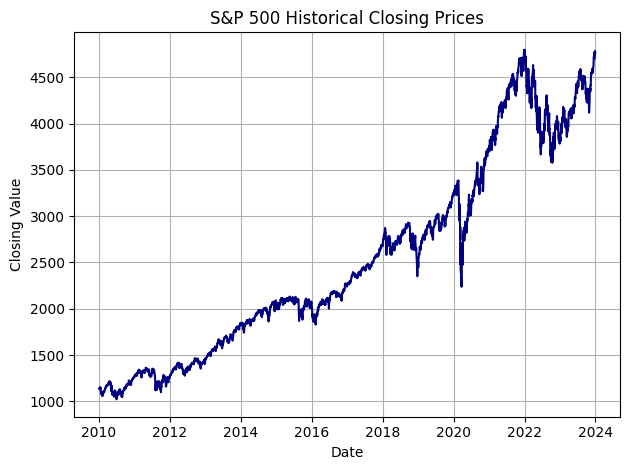

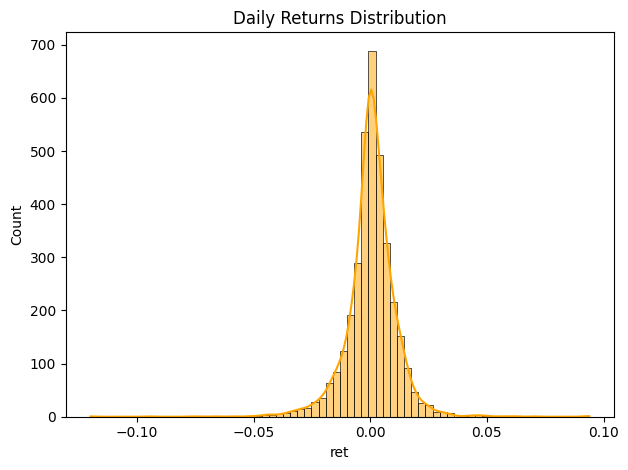

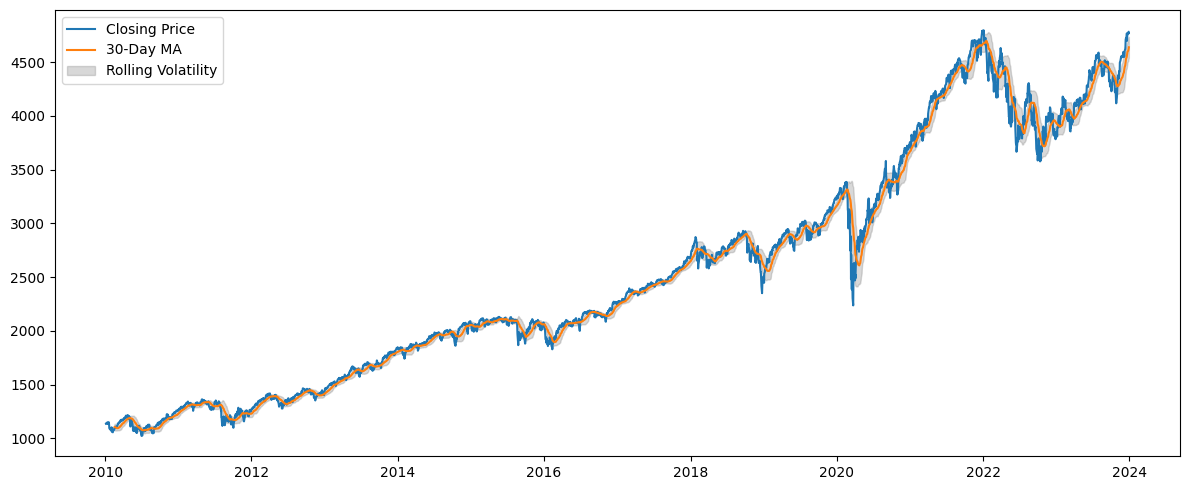

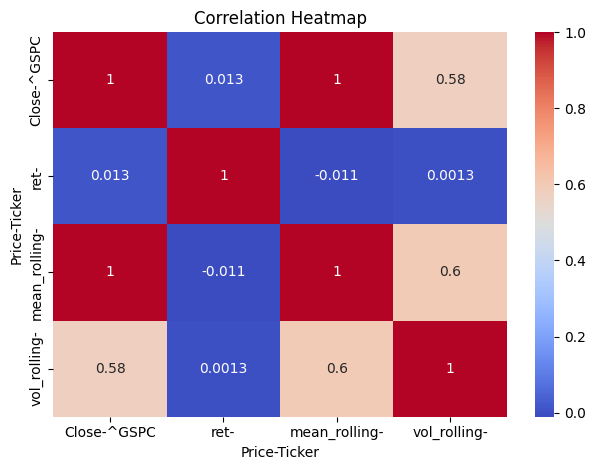

c:\Users\ksoha\OneDrive\Documents\GitHub\collegecourses\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


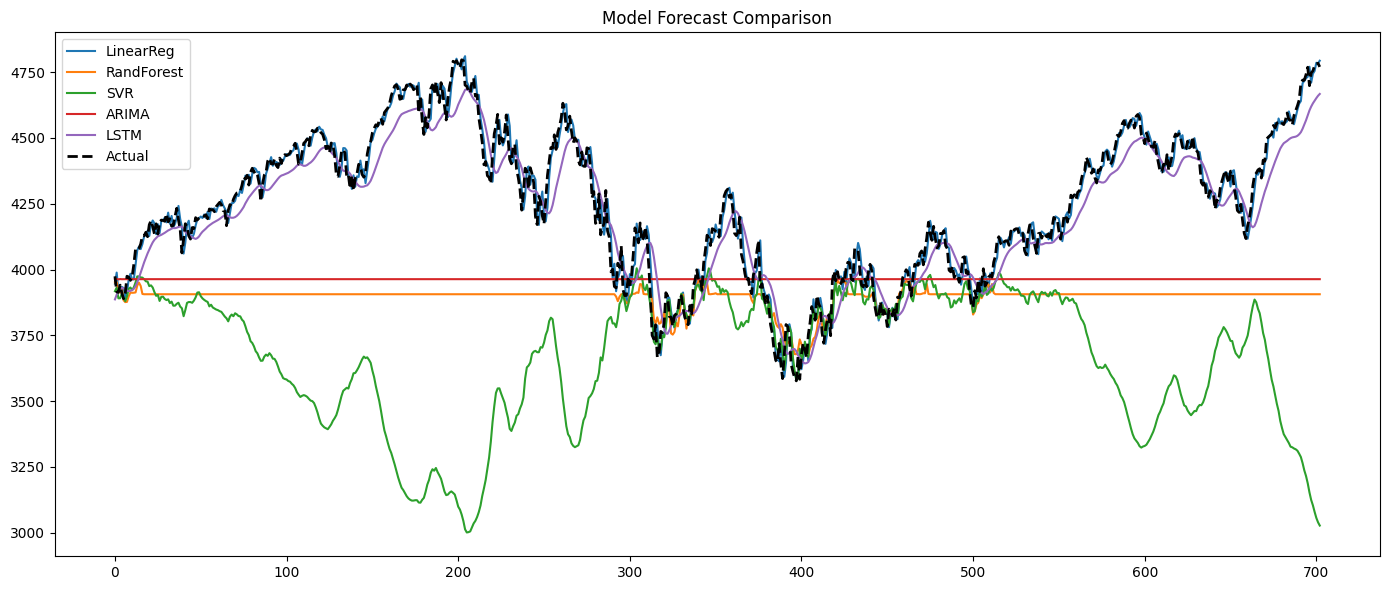

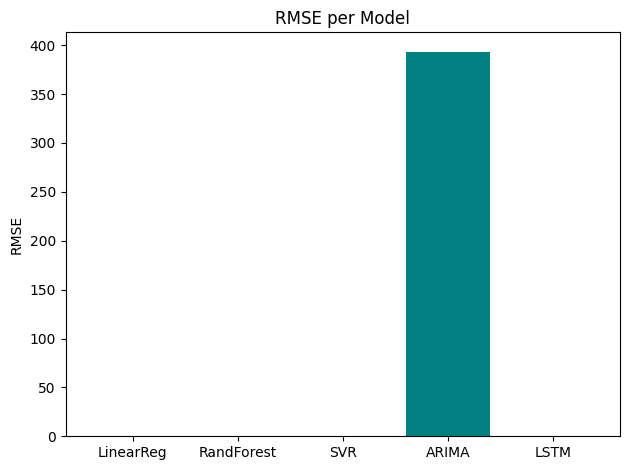


Model Evaluation Summary:
                RMSE       MAE      R2
LinearReg     0.0125    0.0095  0.9704
RandForest    0.1149    0.0950 -1.4884
SVR           0.2001    0.1524 -6.5451
ARIMA       393.5057  326.8966 -1.0479
LSTM          0.0250    0.0208  0.8821


In [12]:
# ANALYTIC MODELING OF S&P 500 - COLLEGE LEVEL WRITEUP WITH HANDWRITTEN VIBE

import yfinance as yf_fetch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from math import sqrt

# -- Data Retrieval & Prep --
ticker = '^GSPC'
dataframe = yf_fetch.download(ticker, start='2010-01-01', end='2024-01-01')
dataframe = dataframe[['Close']].dropna()
dataframe['ret'] = dataframe['Close'].pct_change()
dataframe.dropna(inplace=True)

# -- Visual Diagnostics --
plt.plot(dataframe['Close'], color='navy')
plt.title('S&P 500 Historical Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Value')
plt.grid(True)
plt.tight_layout()
plt.show()

sns.histplot(dataframe['ret'], bins=70, kde=True, color='orange')
plt.title('Daily Returns Distribution')
plt.tight_layout()
plt.show()

roll_window = 30
dataframe['mean_rolling'] = dataframe['Close'].rolling(roll_window).mean()
dataframe['vol_rolling'] = dataframe['Close'].rolling(roll_window).std()

plt.figure(figsize=(12, 5))
plt.plot(dataframe['Close'], label='Closing Price')
plt.plot(dataframe['mean_rolling'], label='30-Day MA')
plt.fill_between(dataframe.index,
                 dataframe['mean_rolling'] - dataframe['vol_rolling'],
                 dataframe['mean_rolling'] + dataframe['vol_rolling'],
                 alpha=0.3, color='gray', label='Rolling Volatility')
plt.legend()
plt.tight_layout()
plt.show()

sns.heatmap(dataframe.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# -- Feature Scaling --
scaler = MinMaxScaler()
dataframe['scaled'] = scaler.fit_transform(dataframe[['Close']])

# -- Function to Create Supervised Dataset --
def build_series(data, lags=10):
    features, targets = [], []
    for i in range(len(data) - lags):
        features.append(data[i:i+lags])
        targets.append(data[i+lags])
    return np.array(features), np.array(targets)

look_back = 10
X, y = build_series(dataframe['scaled'].values, lags=look_back)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

metrics_rmse, metrics_mae, metrics_r2 = {}, {}, {}
model_outputs = pd.DataFrame(index=range(len(y_test)))

# -- Linear Regression --
linreg = LinearRegression()
linreg.fit(X_train.reshape(len(X_train), -1), y_train)
lin_pred = linreg.predict(X_test.reshape(len(X_test), -1))
metrics_rmse['LinearReg'] = sqrt(mean_squared_error(y_test, lin_pred))
metrics_mae['LinearReg'] = mean_absolute_error(y_test, lin_pred)
metrics_r2['LinearReg'] = r2_score(y_test, lin_pred)
model_outputs['LinearReg'] = scaler.inverse_transform(lin_pred.reshape(-1, 1)).flatten()

# -- Random Forest --
rf_model = RandomForestRegressor(n_estimators=50, max_depth=10)
rf_model.fit(X_train.reshape(len(X_train), -1), y_train)
rf_pred = rf_model.predict(X_test.reshape(len(X_test), -1))
metrics_rmse['RandForest'] = sqrt(mean_squared_error(y_test, rf_pred))
metrics_mae['RandForest'] = mean_absolute_error(y_test, rf_pred)
metrics_r2['RandForest'] = r2_score(y_test, rf_pred)
model_outputs['RandForest'] = scaler.inverse_transform(rf_pred.reshape(-1, 1)).flatten()

# -- Support Vector Regression --
svr = SVR(C=1, epsilon=0.01)
svr.fit(X_train.reshape(len(X_train), -1), y_train)
svr_pred = svr.predict(X_test.reshape(len(X_test), -1))
metrics_rmse['SVR'] = sqrt(mean_squared_error(y_test, svr_pred))
metrics_mae['SVR'] = mean_absolute_error(y_test, svr_pred)
metrics_r2['SVR'] = r2_score(y_test, svr_pred)
model_outputs['SVR'] = scaler.inverse_transform(svr_pred.reshape(-1, 1)).flatten()

# -- ARIMA Forecasting --
full_close = dataframe['Close'].values
train_arima, test_arima = full_close[:-len(y_test)], full_close[-len(y_test):]
arima_model = ARIMA(train_arima, order=(5, 1, 0)).fit()
arima_pred = arima_model.forecast(len(test_arima))
metrics_rmse['ARIMA'] = sqrt(mean_squared_error(test_arima, arima_pred))
metrics_mae['ARIMA'] = mean_absolute_error(test_arima, arima_pred)
metrics_r2['ARIMA'] = r2_score(test_arima, arima_pred)
model_outputs['ARIMA'] = arima_pred

# -- LSTM Network --
X_train_seq = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_seq = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

lstm_net = Sequential()
lstm_net.add(LSTM(50, input_shape=(look_back, 1)))
lstm_net.add(Dense(1))
lstm_net.compile(optimizer='adam', loss='mse')
lstm_net.fit(X_train_seq, y_train, epochs=12, batch_size=30, verbose=0)

lstm_pred = lstm_net.predict(X_test_seq)
metrics_rmse['LSTM'] = sqrt(mean_squared_error(y_test, lstm_pred))
metrics_mae['LSTM'] = mean_absolute_error(y_test, lstm_pred)
metrics_r2['LSTM'] = r2_score(y_test, lstm_pred)
model_outputs['LSTM'] = scaler.inverse_transform(lstm_pred).flatten()

# -- Actual Values --
actuals = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
model_outputs['Actual'] = actuals

# -- Plot Final Comparison --
plt.figure(figsize=(14, 6))
for col in ['LinearReg', 'RandForest', 'SVR', 'ARIMA', 'LSTM']:
    plt.plot(model_outputs[col], label=col)
plt.plot(model_outputs['Actual'], label='Actual', linestyle='--', color='black', linewidth=2)
plt.legend()
plt.title('Model Forecast Comparison')
plt.tight_layout()
plt.show()

# -- RMSE Chart --
plt.bar(metrics_rmse.keys(), metrics_rmse.values(), color='teal')
plt.title('RMSE per Model')
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()

# -- Summary Table --
print("\nModel Evaluation Summary:")
print(pd.DataFrame({
    'RMSE': metrics_rmse,
    'MAE': metrics_mae,
    'R2': metrics_r2
}).round(4))
